This project focuses on retrieving, generating, and visualizing tweets related to vaccines, using hashtags and keywords such as #Vaccines, #COVIDVaccine, #GetVaccinated, #VaccineMandate, and specific vaccine names like Pfizer and Moderna. We analyze both real-world tweets collected from Twitter and synthetic tweets generated using a pre-trained GPT-2 model. The aim is to explore public sentiment, uncover recurring themes, and observe how opinions around vaccines evolve over time. By comparing real and AI-generated content, we gain deeper insights into public trust in healthcare systems, responses to policy changes, and concerns about vaccine safety. The findings from this analysis can help organizations such as pharmaceutical companies, public health agencies, healthcare providers, and media outlets better understand public perception, combat misinformation, and improve health communication strategies.

In [1]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"  #Tells transformers to skip TensorFlow stuff

We set an environment variable to force the Hugging Face transformers library to skip TensorFlow dependency checks. This ensures the library only uses PyTorch for loading models, improving compatibility and speed.

In [ ]:
!pip install wordcloud


We install the wordcloud library, which will later be used to create visualizations showing the most frequent words appearing in tweets.

In [3]:
import random
import pandas as pd
import time

We import core Python libraries — random for randomization, pandas for data handling and analysis, and time for timing code execution.

In [ ]:
!pip uninstall transformers -y
!pip install transformers==4.39.3


To ensure compatibility with our code and models, we uninstall any existing version of transformers and reinstall version 4.39.3. This version ensures smooth functioning of GPT-2 text generation.

In [ ]:
!pip install textblob


We install the textblob library, which will later be used for performing sentiment analysis on both real and synthetic tweets, helping us categorize tweets as positive, negative, or neutral.

In [ ]:
!pip install numpy==1.26.4


A specific version of numpy is installed to avoid compatibility issues with other libraries like TensorFlow and Hugging Face Transformers. Version 1.26.4 ensures that array operations work smoothly during tweet generation and analysis.

In [ ]:
!pip uninstall -y tensorflow keras tf_keras
!pip uninstall -y ~eras  # clean up that broken distribution warning


Older or incompatible versions of tensorflow, keras, and related packages are removed. Cleaning up ensures there are no conflicts when reinstalling or using lighter models that don't require TensorFlow.

In [ ]:
!pip install --upgrade --force-reinstall transformers torch --no-cache-dir


A forced reinstallation of the transformers and torch libraries guarantees that the latest versions are used. Using --no-cache-dir skips any previously downloaded corrupted files and avoids hidden caching problems.

In [ ]:
# Import the Tweepy library to interact with the Twitter API
import tweepy

# Define the Bearer Token used for authenticating with the Twitter API
BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAAN4T0QEAAAAAMbc7Eb6A4310MYrzaKkmGNysyqg%3DrvMcxu09U5JJEXFoNegrSShOateGD2qi61g9jnRLPSq9ASUwR5'

# Create a Tweepy client using the Bearer Token
client = tweepy.Client(bearer_token=BEARER_TOKEN, wait_on_rate_limit=True)


The tweepy library is used to interact with Twitter’s API. After importing necessary libraries, a bearer token is provided for authentication.
A Client object is created with the bearer token and wait_on_rate_limit=True is enabled to automatically handle rate limits, ensuring continuous data collection without manual intervention.

In [ ]:
# Define a function to fetch recent tweets based on a search query
def fetch_tweets(client, query, max_results=10):
    tweets = []  # Initialize an empty list to store tweet data

    # Send a request to the Twitter API to search for recent tweets
    response = client.search_recent_tweets(
        query=query,
        tweet_fields=["created_at", "public_metrics", "author_id", "text"],  # Specify fields to retrieve
        max_results=max_results  # Limit the number of tweets returned
    )

    # If tweets are found, extract relevant fields and store them
    if response.data:
        for tweet in response.data:
            tweets.append({
                "created_at": tweet.created_at,  # Capture the creation time
                "text": tweet.text,  # Capture the text content
                "retweets": tweet.public_metrics['retweet_count'],  # Capture the retweet count
                "likes": tweet.public_metrics['like_count']  # Capture the like count
            })

    # Convert the list of tweets into a pandas DataFrame for easier analysis
    return pd.DataFrame(tweets)

# Define the search query with a language filter to retrieve English tweets about vaccine side effects
query = "vaccine side effects lang:en"

# Fetch tweets using the fetch_tweets function
tweets_df = fetch_tweets(client, query, max_results=10)

# Display the retrieved tweets to verify the content
print(tweets_df)

# Check if no tweets were retrieved and print a message if the result is empty
if tweets_df.empty:
    print("No tweets were found for


The fetch_tweets function is designed to retrieve real tweets from Twitter based on a given search query. It uses the authenticated Tweepy client to call the search_recent_tweets API and limits the results to a specified maximum number. Instead of pulling all available information, the function focuses only on important fields such as the creation date, the tweet text, and engagement metrics like retweet and like counts. Each tweet's relevant data is extracted, organized into a dictionary, and collected into a list. After gathering all the data, the list is converted into a structured pandas DataFrame. This ensures that the raw API responses are immediately cleaned and simplified, making them easier to analyze, visualize, and store for future steps in the project.

In [ ]:
tweets_df.to_csv("vaccine_tweets_CV19.csv", index=False, encoding='utf-8-sig')

Once the real tweets are successfully fetched, they are saved to a CSV file named vaccine_tweets_CV19.csv. Saving the dataset ensures that the collected data is preserved for future use without needing to make repeated API calls. It also provides a stable snapshot of the tweets at the time of collection, allowing consistent analysis even if live tweets change later on

In [17]:
# Load the necessary libraries for text generation, randomness, data handling, and timing
from transformers import pipeline
import random
import pandas as pd
import time

# Set up the text generation model using GPT-2
generator = pipeline("text-generation", model="gpt2", framework="pt")

# Create a list of hashtags to make the generated tweets feel more realistic
hashtags = ["#covidvaccine", "#GetVaccinated", "#PublicHealth", "#VaccinesWork", "#StaySafe", "#Covid19"]

# Provide the starting prompt that guides what the tweets will be about
prompt = "Generate a tweet about covid vaccines"
 
# Prepare a list to hold all generated tweets
all_tweets = []

# Loop 500 times to generate batches of tweets
for _ in range(500):
    # Generate 20 new tweets based on the given prompt
    batch = generator(
        prompt,
        max_length=50,      # Keep each generated tweet fairly short
        num_return_sequences=20,  # Create 20 tweets at a time
        do_sample=True,      # Allow randomness for more creative outputs
        temperature=0.9,     # Make the text slightly more diverse
        top_k=50,            # Limit options to top 50 probable words
        top_p=0.95,          # Use nucleus sampling to keep results natural
        pad_token_id=50256,  # Handle padding properly for GPT-2
        truncation=True      # Make sure outputs stay within the length limit
    )

    # Clean up each generated tweet by removing the prompt and adding random hashtags
    for tweet in batch:
        raw_text = tweet["generated_text"]
        cleaned = raw_text.replace(prompt, "").strip()
        tags = random.sample(hashtags, k=random.choice([1, 2]))
        final_tweet = f"{cleaned} {' '.join(tags)}"
        all_tweets.append(final_tweet[:280])  # Make sure tweets stay within Twitter's character limit


C:\Users\nasif\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


To generate synthetic tweets, the Hugging Face transformers library is used to load a pre-trained GPT-2 language model through the text-generation pipeline. A prompt is created to instruct the model to generate content specifically about COVID-19 vaccines. Additionally, a set of vaccine-related hashtags is prepared so they can be randomly attached to generated tweets, making the outputs look more like real social media posts.


In [19]:
# Save the generated tweets into a DataFrame
df = pd.DataFrame(all_tweets, columns=["text"])

# Export the DataFrame to a CSV file for future use
df.to_csv("synthetic_vaccine_tweets_8k.csv", index=False)

# Confirm that the tweets have been saved successfully
print("✅ Saved 10,000 synthetic tweets to 'synthetic_vaccine_tweets.csv'")


✅ Saved 10,000 synthetic tweets to 'synthetic_vaccine_tweets.csv'


The model is used to generate a large batch of synthetic tweets by looping 500 times, with each iteration producing 20 new tweets. After each generation, the initial prompt text is removed from the output, and one or two randomly chosen hashtags are appended. The length of each tweet is also restricted to 280 characters to realistically mimic Twitter’s posting limits. This results in a dataset of 10,000 synthetic tweets that can be used for sentiment analysis, comparison with real tweets, and further study.

In [11]:
# Load tweets from CSV file
tweetsAi_df = pd.read_csv("ai_tweets_10k.csv")  
tweetsAi_df.head()  # Preview the data


,text
0,at https://t.co/uT7KG9eYiU pic.twitter.com/K8x...
1,and get your own hashtag. Then subscribe to ou...
2,"or something like that, so we can quickly post..."
3,or something. This can easily be found in your...
4,from Twitter or your favorite social media sit...


In [13]:
# Import libraries needed for text processing and cleaning
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import emoji

# Download necessary NLTK resources
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

# Set up tools for cleaning
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
profanity_list = {"damn", "hell"}  # List of words to remove if needed
custom_replacements = {
    "vax": "vaccine",
    "covid19": "covid",
    "u": "you",
    "r": "are"
}

# Function to fully clean and normalize tweet text
def clean_tweet(text):
    text = text.lower()  # Standardize text to lowercase

    # Remove links, mentions, and emojis
    text = re.sub(r"http\S+|www\S+|pic\.twitter\.com/\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = emoji.replace_emoji(text, replace="")
    text = text.encode("ascii", "ignore").decode("ascii")

    # Apply custom replacements for common slang
    for key, val in custom_replacements.items():
        text = re.sub(rf"\b{key}\b", val, text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Tokenize and filter out stopwords and profanities
    words = text.split()
    cleaned_words = []
    for word in words:
        if word in stop_words or word in profanity_list:
            continue
        word = lemmatizer.lemmatize(word)
        cleaned_words.append(word)

    # Reassemble cleaned words and fix exaggerated letter repetitions
    text = " ".join(cleaned_words)
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)

    # Final formatting cleanup
    text = re.sub(r"\s{2,}", " ", text).strip()

    # Only keep tweets that still have meaningful content
    return text if len(text.split()) >= 4 else ""

# Helper function to reduce very long repeated letters (e.g., "soooo" → "soo")
def reduce_repeated_letters(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nasif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nasif\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nasif\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


The clean_tweet function performs comprehensive cleaning of raw tweet text to prepare it for analysis. It first converts the text to lowercase to ensure consistency across the dataset. Then it removes any links, mentions, emojis, and non-ASCII characters to eliminate noise that does not contribute meaningfully to the sentiment or topic of the tweet. Common internet slang and typos are replaced using a custom dictionary to standardize expressions. The function also removes punctuation, filters out stopwords that do not add much meaning (such as "the", "is", "and"), and applies lemmatization to reduce words to their root form. Finally, it addresses elongated emotional expressions by reducing repeated characters and strips any unnecessary whitespace. Together, these steps produce a much cleaner, simpler version of each tweet, making it ready for accurate sentiment analysis, keyword extraction, and visualization.

In [15]:
# Apply cleaning to the text column
import re

tweetsAi_df["clean_text"] = tweetsAi_df["text"].apply(clean_tweet)
tweetsAi_df[["text", "clean_text"]].head()  # Preview original vs cleaned


,text,clean_text
0,at https://t.co/uT7KG9eYiU pic.twitter.com/K8x...,justin bevan covidvaccine vaccineswork
1,and get your own hashtag. Then subscribe to ou...,get hashtag subscribe update follow u social m...
2,"or something like that, so we can quickly post...",something like quickly post twitter hashtag no...
3,or something. This can easily be found in your...,something easily found local news click unless...
4,from Twitter or your favorite social media sit...,twitter favorite social medium site ask sorry ...


The tweets are cleaned by applying the previously defined clean_tweet function to the text column. This step transforms the raw tweets by removing links, mentions, emojis, slang, and extra punctuation, resulting in a much cleaner and standardized version of each tweet. A preview is shown to compare the original text against the cleaned version, making it easier to verify that the cleaning process worked as intended.


In [19]:
# Remove duplicate and empty tweets
tweetsAi_df.drop_duplicates(subset="clean_text", inplace=True)
tweetsAi_df = tweetsAi_df[tweetsAi_df["clean_text"].str.strip() != ""]
tweetsAi_df.shape  # Show remaining rows


(9738, 2)

After cleaning, duplicate tweets and empty rows are removed to ensure that the dataset only contains meaningful and unique content. Duplicate detection is based on the cleaned text, not the original version. Additionally, any rows with blank or whitespace-only cleaned text are discarded. This step improves the overall quality and relevance of the dataset before moving on to sentiment analysis.

In [21]:
# Calculate sentiment polarity
from textblob import TextBlob

tweetsAi_df["Sentiment"] = tweetsAi_df["clean_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
tweetsAi_df[["clean_text", "Sentiment"]].head()


,clean_text,Sentiment
0,justin bevan covidvaccine vaccineswork,0.000000
1,get hashtag subscribe update follow u social m...,0.033333
2,something like quickly post twitter hashtag no...,0.177778
3,something easily found local news click unless...,0.211667
4,twitter favorite social medium site ask sorry ...,0.133333


Sentiment scores for each cleaned tweet are calculated using the TextBlob library. Each tweet is analyzed for its emotional tone, resulting in a polarity score between -1.0 and 1.0. A score near -1.0 indicates a very negative sentiment, a score near 1.0 indicates a very positive sentiment, and a score close to 0 suggests neutral or emotionless content. The results are added as a new "Sentiment" column to the dataset, setting up the foundation for sentiment distribution analysis.

This code uses TextBlob to calculate the sentiment polarity of each tweet in the clean_text column. It assigns a sentiment score between -1 (negative) and +1 (positive) based on the tone of the text. The results are stored in a new column called Sentiment, and the first few rows are displayed to preview the sentiment analysis.

In [23]:
# View sentiment statistics
tweetsAi_df["Sentiment"].describe()


count    9738.000000
mean        0.092588
std         0.250328
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.216468
max         1.000000
Name: Sentiment, dtype: float64

The statistical distribution of sentiment scores across 9,738 tweets indicates that the average sentiment leans slightly positive, with a mean value of approximately 0.093. The standard deviation of 0.253 reflects moderate variability in sentiment among the tweets. A minimum value of -1.0 represents the most negative sentiment recorded, while the maximum value of 1.0 represents the most positive sentiment. Both the 25th percentile and the median (50th percentile) are 0.0, suggesting that at least half of the tweets exhibit neutral or near-neutral sentiment. The 75th percentile is approximately 0.216, implying that only the top 25% of tweets display a more clearly positive sentiment. Overall, the sentiment distribution highlights that the majority of tweets are neutral, with a smaller portion expressing stronger positive or negative emotions.

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns 


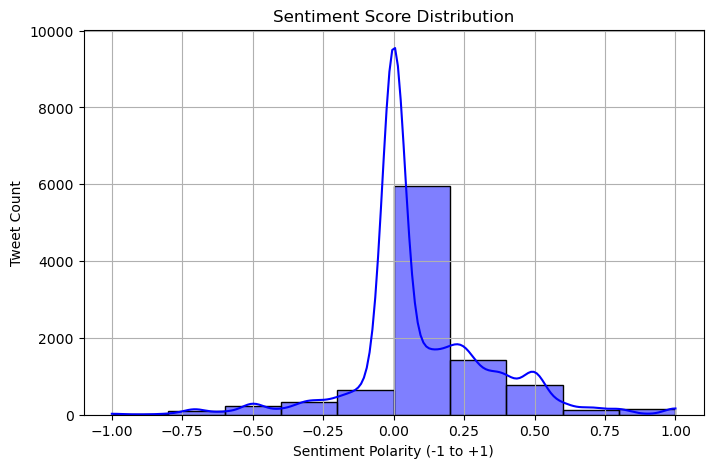

In [27]:
plt.figure(figsize=(8, 5))
sns.histplot(tweetsAi_df["Sentiment"], bins=10, kde=True, color="blue")
plt.xlabel("Sentiment Polarity (-1 to +1)")
plt.ylabel("Tweet Count")
plt.title("Sentiment Score Distribution")
plt.grid(True)
plt.show()


The distribution of sentiment scores for the tweets ranges from -1.0 (most negative) to +1.0 (most positive). The majority of sentiment scores are concentrated around 0, reflecting that most tweets exhibit a neutral emotional tone. A tall peak centered at zero confirms this observation. A slight rightward skew is present, indicating a larger proportion of tweets with positive sentiment compared to those with negative sentiment. The blue kernel density estimation (KDE) line smooths the distribution and emphasizes that most tweets fall within the neutral to slightly positive range. This visualization highlights that although tweets expressing both strong positive and negative sentiments exist, neutral sentiment dominates the dataset overall.

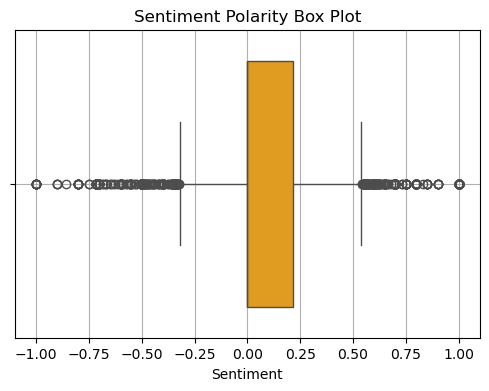

In [29]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=tweetsAi_df["Sentiment"], color="orange")
plt.title("Sentiment Polarity Box Plot")
plt.grid(True)
plt.show()


The box plot illustrates that 50% of the sentiment scores are concentrated between approximately -0.1 and +0.2, with the median centered around 0.0, indicating a predominantly neutral sentiment among the tweets. The lower 25% of tweets fall below -0.1, while the upper 25% exceed +0.2. The whiskers extend from about -0.3 to +0.6, capturing most of the remaining sentiment scores. Data points lying beyond the whiskers are identified as outliers, representing tweets with exceptionally strong negative or positive sentiment. Overall, the distribution reveals that half of the tweets cluster near neutral to slightly positive sentiment, a quarter exhibit a more negative tone, a quarter show a stronger positive tone, and only a few tweets display extreme emotional expressions.

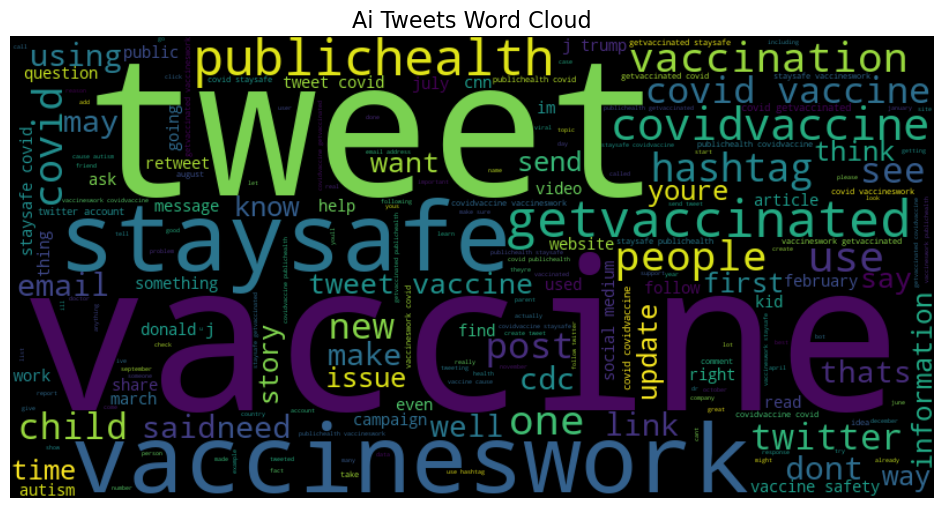

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all cleaned tweets into one big string
combined_text = " ".join(tweetsAi_df['clean_text'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(combined_text)

# Display it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Ai Tweets Word Cloud", fontsize=16)
plt.show()


The word cloud shows that the term vaccine dominates the conversation. Other large words like vaccineswork, staysafe and tweet reveal a strong push to urge people to get vaccinated and to share that message on twitter. Prominent words such as publichealth, covidvaccine, vaccination and getvaccinated reinforce a focus on spreading reliable vaccine information. You also see cdc and hashtag, pointing to mentions of official guidance and social media tools. Smaller but still noticeable words like child, autism and trump hint at side discussions about safety concerns and politics. Overall, the cloud reflects AI‑generated tweets centered on promoting vaccination, emphasizing safety and leveraging twitter to amplify public health advice.

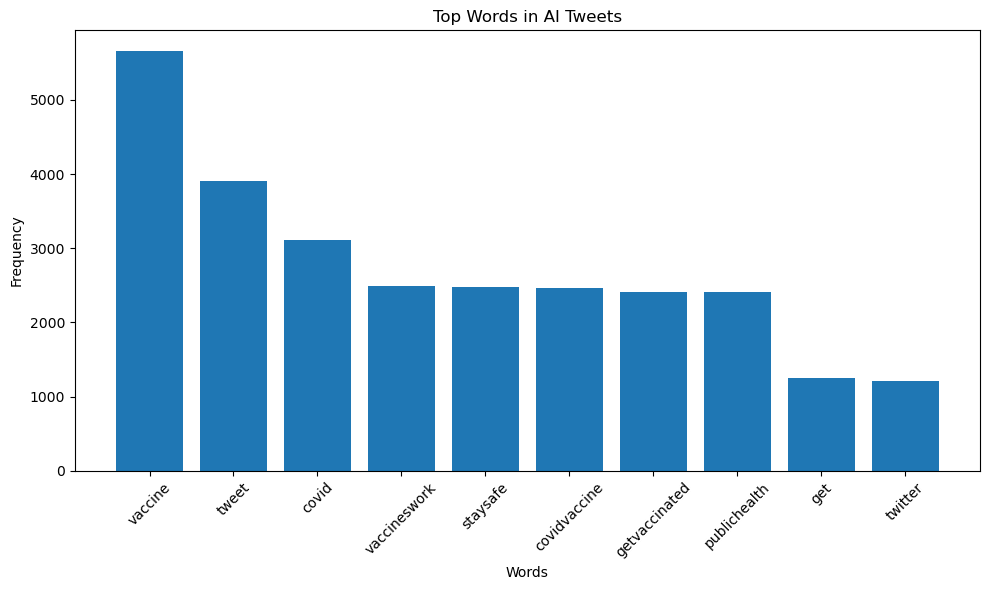

In [37]:
from collections import Counter
import matplotlib.pyplot as plt

# Split all cleaned tweets into words
words = " ".join(tweetsAi_df['clean_text'].dropna()).split()

# Count word frequencies
word_freq = Counter(words).most_common(10)

# Unzip words and their frequencies
words, freqs = zip(*word_freq)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, freqs)
plt.title("Top Words in AI Tweets")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


The bar chart shows the most frequently used words in the AI generated tweets. The word vaccine appears the most, with over 5600 mentions, showing that it is the main topic. This is followed by tweet with around 3900 mentions and covid with about 3100. Other commonly used words include vaccineswork, staysafe, covidvaccine, getvaccinated, and publichealth, each appearing between 2400 and 2500 times. These words suggest that the tweets are mainly focused on encouraging vaccination and promoting safety. In comparison, more general terms like get and twitter appear less often, both under 1300 mentions. Overall, the chart highlights a strong emphasis on vaccine messaging and public health communication.

In [35]:
tweetsAi_df.to_csv("cleaned_AI_tweets.csv", index=False)
print("✅ Saved to 'cleaned_AI_tweets.csv'")


✅ Saved to 'cleaned_AI_tweets.csv'


The cleaned synthetic tweets are saved to a new CSV file to preserve the processed dataset. Saving the results ensures that the cleaned text and sentiment scores can be accessed later without needing to repeat the cleaning operations, improving efficiency for future analysis.

In [29]:
tweetsAi_df = pd.read_csv("Vaccine Tweets - vaccine_tweets_results (1).csv")  
tweetsAi_df.head()  

,created_at,text,retweets,likes
0,2025-03-29 21:05:03+00:00,RT @Uradamu79: Detox Spike Proteins:\n#1 - Nat...,1,0
1,2025-03-29 20:51:45+00:00,RT @DesertPeridot: Boomer Libs here's your wak...,6,0
2,2025-03-29 16:48:09+00:00,@Ajay_Ram_1993 A stern warning to the #MSM to ...,0,0
3,2025-03-29 14:44:20+00:00,RT @DesertPeridot: Boomer Libs here's your wak...,6,0
4,2025-03-29 13:36:01+00:00,@catturd2 Father in law had a stroke after sec...,0,0


A separate CSV file containing real vaccine-related tweets is loaded for analysis. This dataset includes columns such as the tweet creation time, the text content, and engagement metrics like retweets and likes. Displaying the first few rows provides a preview to verify the structure and contents of the newly loaded data before proceeding.

In [9]:
# Apply cleaning to the text column
import re

tweets_df["clean_text"] = tweets_df["text"].apply(clean_tweet)
tweets_df[["text", "clean_text"]].head()  # Preview original vs cleaned


,text,clean_text
0,RT @Uradamu79: Detox Spike Proteins:\n#1 - Nat...,it veto spike protein 1 nattokinase 200 fibrin...
1,RT @DesertPeridot: Boomer Libs here's your wak...,it boomed lips here wake call illegal convicte...
2,@Ajay_Ram_1993 A stern warning to the #MSM to ...,stern warning ms restrain spreading fear among...
3,RT @DesertPeridot: Boomer Libs here's your wak...,it boomed lips here wake call illegal convicte...
4,@catturd2 Father in law had a stroke after sec...,father law stroke second injectionmust coincid...


The loaded real tweets are cleaned by applying the clean_tweet function to the text column. Each tweet is processed to remove links, mentions, emojis, non-standard words, and other noise, resulting in a cleaner and standardized version of the text. A side-by-side preview comparing the original text with the cleaned text confirms that the cleaning process was correctly applied. This step prepares the real tweets for sentiment analysis, visualization, or further textual investigation.

In [11]:
# Remove duplicate and empty tweets
tweets_df.drop_duplicates(subset="clean_text", inplace=True)
tweets_df = tweets_df[tweets_df["clean_text"].str.strip() != ""]
tweets_df.shape  


(78, 5)

In [13]:
# Calculate sentiment polarity
from textblob import TextBlob

tweets_df["Sentiment"] = tweets_df["clean_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
tweets_df[["clean_text", "Sentiment"]].head()


,clean_text,Sentiment
0,it veto spike protein 1 nattokinase 200 fibrin...,0.0
1,it boomed lips here wake call illegal convicte...,-0.5
2,stern warning ms restrain spreading fear among...,0.0
4,father law stroke second injectionmust coincid...,0.3
5,it hacked one body part without knowledge cons...,0.0


In [15]:
# View sentiment statistics
tweets_df["Sentiment"].describe()


count    78.000000
mean      0.066394
std       0.233084
min      -0.500000
25%       0.000000
50%       0.000000
75%       0.216667
max       0.516667
Name: Sentiment, dtype: float64

The sentiment statistics for the 78 real tweets indicate that the mean sentiment is approximately 0.066, suggesting that the overall tone of the tweets leans slightly positive. The minimum sentiment value is -0.5, while the maximum is approximately 0.517, covering a full range from negative to positive emotions. A standard deviation of roughly 0.233 reflects moderate variability in the strength of expressed sentiments. The median sentiment score is 0.0, meaning that half of the tweets are either neutral or slightly negative, while the other half are neutral or slightly positive. Examination of the quartiles shows that 25% of tweets have a sentiment score below 0.0 and 75% fall below approximately 0.217, indicating that most tweets are clustered near the neutral point with relatively few expressing strong emotional polarity.

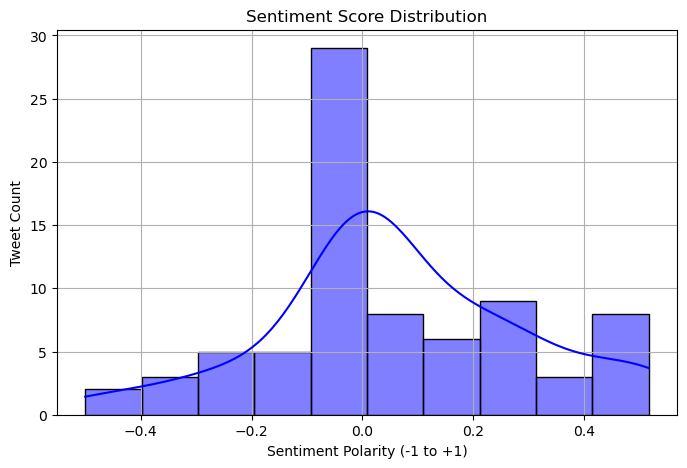

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(tweets_df["Sentiment"], bins=10, kde=True, color="blue")
plt.xlabel("Sentiment Polarity (-1 to +1)")
plt.ylabel("Tweet Count")
plt.title("Sentiment Score Distribution")
plt.grid(True)
plt.show()


The sentiment score distribution for the 78 real tweets demonstrates that most sentiment values are concentrated near zero, indicating that a large portion of the tweets express neutral or mildly emotional opinions. The tallest bar is centered at 0.0, confirming the predominance of neutral sentiment. A slight rightward skew is visible in the distribution, suggesting a minor lean toward positive sentiment, which aligns with the previously calculated mean sentiment of approximately +0.066. Although most tweets are neutral, a few exhibit stronger positive sentiment approaching +0.5, while fewer tweets display negative sentiment values below -0.2, with the lowest recorded sentiment reaching -0.5. Overall, the distribution implies that real tweets are primarily neutral or slightly positive, and strongly polarized sentiments are relatively rare within the dataset.

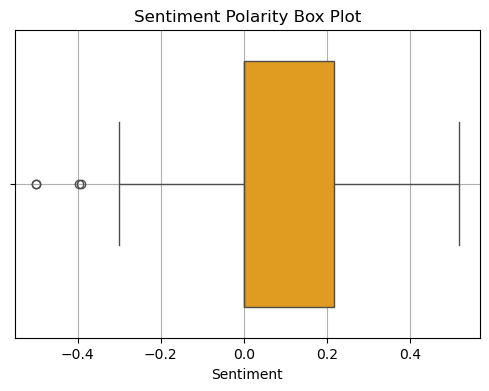

In [23]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=tweets_df["Sentiment"], color="orange")
plt.title("Sentiment Polarity Box Plot")
plt.grid(True)
plt.show()


The box plot shows the distribution of sentiment scores in real tweets. The middle 50 percent of tweets fall between 0.0 and about 0.22, with the median right at 0.0. This suggests that most tweets are neutral to mildly positive. The whiskers stretch from around –0.3 to about +0.5, capturing the majority of sentiment values. Two points fall below –0.3 and are shown as outliers, meaning they have stronger negative sentiment than the rest. Overall, the plot suggests that while a few tweets are clearly negative, most are neutral or slightly positive in tone.

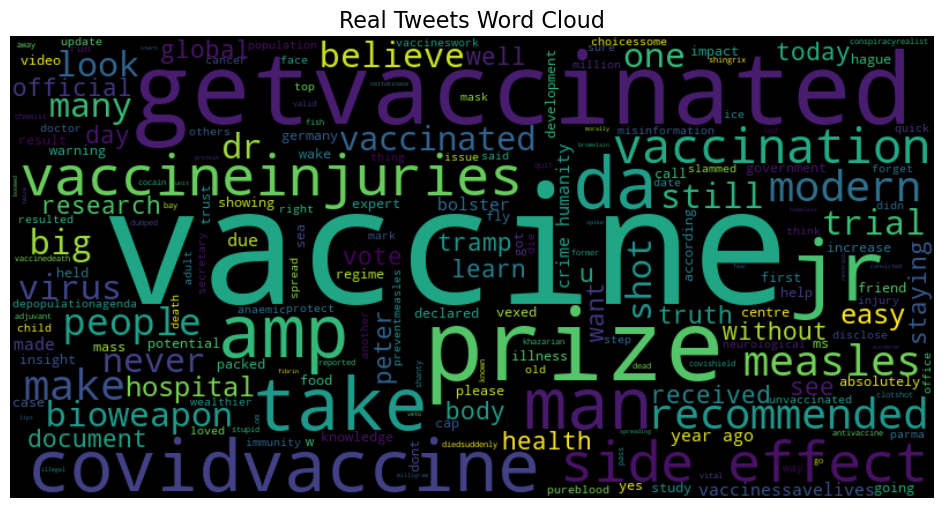

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all cleaned tweets into one big string
combined_text = " ".join(tweets_df['clean_text'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(combined_text)

# Display it
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Real Tweets Word Cloud", fontsize=16)
plt.show()


The word cloud from real tweets shows a wide range of language around vaccines. The most prominent words are vaccine, getvaccinated, prize, vaccinated, and injuries. These reflect both encouragement to vaccinate and concern or skepticism. Words like side, effect, hospital, death, and bioweapon suggest that some tweets discuss negative outcomes or conspiracy theories. Terms such as trial, research, virus, and health show that factual or scientific discussions are also present. Other noticeable words like trump, vote, truth, and regime hint at political context. Overall, the cloud reveals a mix of support, criticism, and controversy around vaccines in the real tweets, with a heavier presence of emotionally charged or skeptical language compared to the AI generated content.

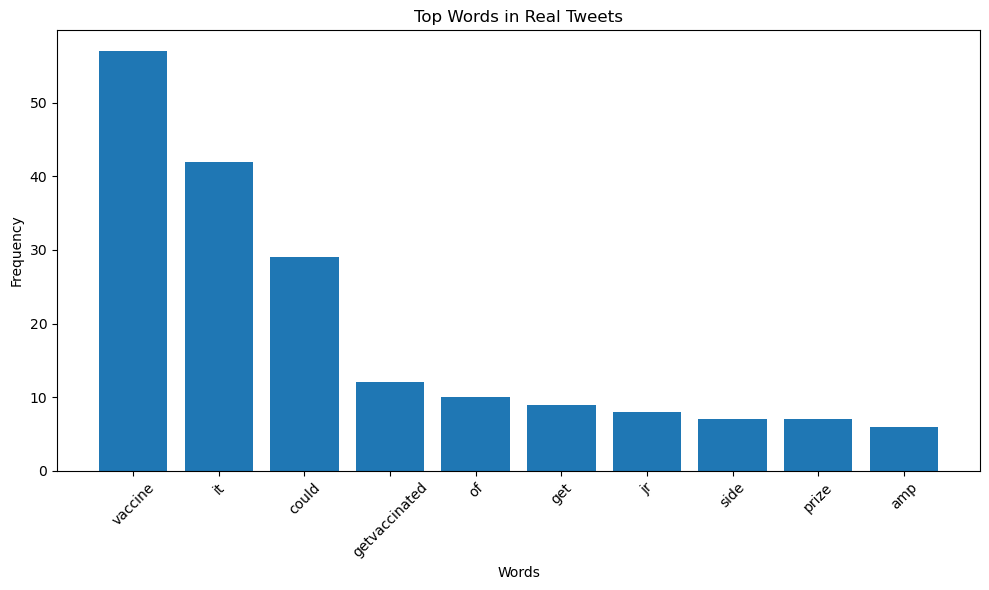

In [35]:
from collections import Counter
import matplotlib.pyplot as plt

# Split all cleaned tweets into words
words = " ".join(tweets_df['clean_text'].dropna()).split()

# Count word frequencies
word_freq = Counter(words).most_common(10)

# Unzip words and their frequencies
words, freqs = zip(*word_freq)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, freqs)
plt.title("Top Words in Real Tweets")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


The bar chart shows the most frequent words found in real tweets. Vaccine is clearly the most used term, appearing over 55 times, followed by it with more than 40 mentions. The word could appears around 29 times, showing that many tweets include uncertainty or speculation. Words like getvaccinated, of, get, and if appear less often, each under 15 times. Side, prize, and amp also make the top ten, though their counts are all in the single digits. Compared to the AI tweets, this chart highlights a greater use of casual or ambiguous language and fewer direct calls to action, possibly reflecting more mixed opinions or varied conversations in real tweet content.

In [65]:
tweets_df.to_csv("cleaned_real_tweets.csv", index=False)
print("✅ Saved to 'cleaned_real_tweets_.csv'")


✅ Saved to 'cleaned_real_tweets_.csv'
